In [1]:
import numpy as np
import sklearn
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

Open the data file

In [2]:
data_df = pd.read_csv('creditcard.csv')

In [3]:
data_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [4]:
#check if the df contains any NaN values

data_df.isnull().values.any()

False

First, lets identify how many classes there are and how many correspond to each

In [5]:
classes = data_df.Class.unique()
print(classes)

[0 1]


In [6]:
print('class corresponding to non-fraud', classes[0],': ', len(data_df[data_df.Class==classes[0]]))
print('class corresponding to fraud', classes[1],': ', len(data_df[data_df.Class==classes[1]]))

class corresponding to non-fraud 0 :  284315
class corresponding to fraud 1 :  492


There is such a large asymmetry between 'fraud' and 'non-fraud',that the algorithm will be completely biased for class 0. This will give us an amazing accuracy, as most of the data points will be confused by 'non-fraud' after running the algorith. This can be seen looking at the confusion matrix and F1 score

In [7]:
#transform the dataframe to an array
data = data_df.as_matrix()

X_data = data[:,:(data_df.shape[1]-1)]
y_data = data[:,(data_df.shape[1]-1)]

Split the data into train and test sets

In [8]:
#split the data into training and test data
from sklearn.model_selection import train_test_split

X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, test_size=0.25)

In [9]:
#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_data_train = scaler.fit_transform(X_data_train)
X_data_test = scaler.fit_transform(X_data_test)

In [10]:
#train the algorithm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


#fit decision tree classifier
model_nn = MLPClassifier(hidden_layer_sizes=2, max_iter=2000)
model_nn.fit(X_data_train, y_data_train)

#predict 'y' for test data
y_data_pred_test = model_nn.predict(X_data_test)

#score
print('Accuracy: ', accuracy_score(y_data_test, y_data_pred_test))
print('confusion matrix:', confusion_matrix(y_data_test, y_data_pred_test))
print('F1:', f1_score(y_data_test, y_data_pred_test))

Accuracy:  0.999227549788
confusion matrix: [[71039    23]
 [   32   108]]
F1: 0.79704797048


The accuracy is pretty good (as expected). Nevertheless the F1 score can be substantially improved. 
But what happens if we reduce the ammount of 'non-fraud' data for symmetry?

In [11]:
#this is the data corresponding to fraud
data_fraud_df = data_df[data_df.Class==classes[1]]
data_fraud_df = data_fraud_df.reset_index(drop=True)
data_fraud = data_fraud_df.as_matrix()


#this is the data corresponding to non-fraud
data_nonfraud_df = data_df[data_df.Class==classes[0]]
data_nonfraud_df = data_nonfraud_df.reset_index(drop=True)
data_red_nonfraud_df = \
    data_nonfraud_df.ix[np.random.randint(1, max(data_nonfraud_df.index),max(data_fraud_df.index)+1)]
data_red_nonfraud_df = data_red_nonfraud_df.reset_index(drop=True)

In [12]:
#now lets join both fraud and non-fraud of the same length
data_red_df = pd.concat([data_red_nonfraud_df, data_fraud_df])
data_red = data_red_df.as_matrix()

X_data_red = data_red[:,:(data_red_df.shape[1]-1)]
y_data_red = data_red[:,(data_red_df.shape[1]-1)]

In [13]:
#define train and test of the symmetric data
X_data_red_train, X_data_red_test, y_data_red_train, y_data_red_test =\
            train_test_split(X_data_red, y_data_red, test_size=0.25)

In [14]:
#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_data_red_train = scaler.fit_transform(X_data_red_train)
X_data_red_test = scaler.fit_transform(X_data_red_test)

In [15]:
model_nn.fit(X_data_red_train, y_data_red_train)

#predict 'y' for test data
y_data_red_pred_test = model_nn.predict(X_data_red_test)

#score
print('Accuracy: ', accuracy_score(y_data_red_test, y_data_red_pred_test))
print('confusion matrix:', confusion_matrix(y_data_red_test, y_data_red_pred_test))
print('F1:', f1_score(y_data_red_test, y_data_red_pred_test))

Accuracy:  0.906504065041
confusion matrix: [[117  17]
 [  6 106]]
F1: 0.902127659574


In [18]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

cv = KFold(len(y_data_red_pred_test), 5, shuffle=True, random_state=0)
# by default the score used is the one returned by score method of the estimator (accuracy)
scores = cross_val_score(model_nn, X_data_red_test, y_data_red_pred_test, cv=cv)
print(scores)
print("Mean score: {0:.3f} (+/-{1:.3f})".format(np.mean(scores), sem(scores)))

[ 0.84        0.85714286  0.85714286  0.97959184  0.89795918]
Mean score: 0.886 (+/-0.025)


C:\Users\AnaSolaguren-Beascoa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


The F1 and confusion matrix have already improved. Nevertheless, lets look if this can still be further improved. 

It is interesting to visualise the data to see if there are particular features which can improve the classification. Hence
* We will reduce the dimension of the features to visualize how good the classification currently is
* We will visualise the different features and chose the ones which can improve the classification and drop all the other features

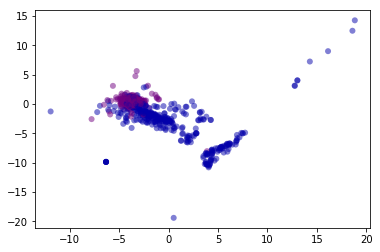

In [19]:

from sklearn.manifold import Isomap
iso = Isomap(n_neighbors=30, n_components=2)

#project the data to 2-dimension features
iso.fit(X_data_red_train[:50,:])
Xdata_red_projected = iso.transform(X_data_red_train)

#visualise the data
plt.scatter(Xdata_red_projected[:, 0], Xdata_red_projected[:, 1], c=y_data_red_train,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral'))

plt.clim(-0.5, 9.5);

It seems the current features don't separate the two classes perfectly. Lets look at the different features and chose the best ones for the classification.

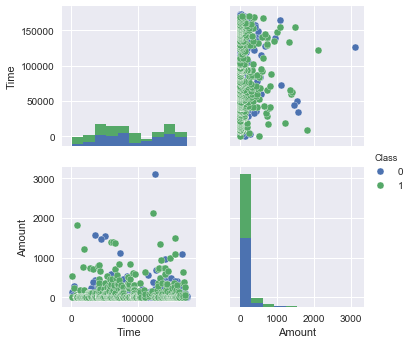

In [20]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.pairplot(data_red_df, hue='Class',vars=['Time', 'Amount']);

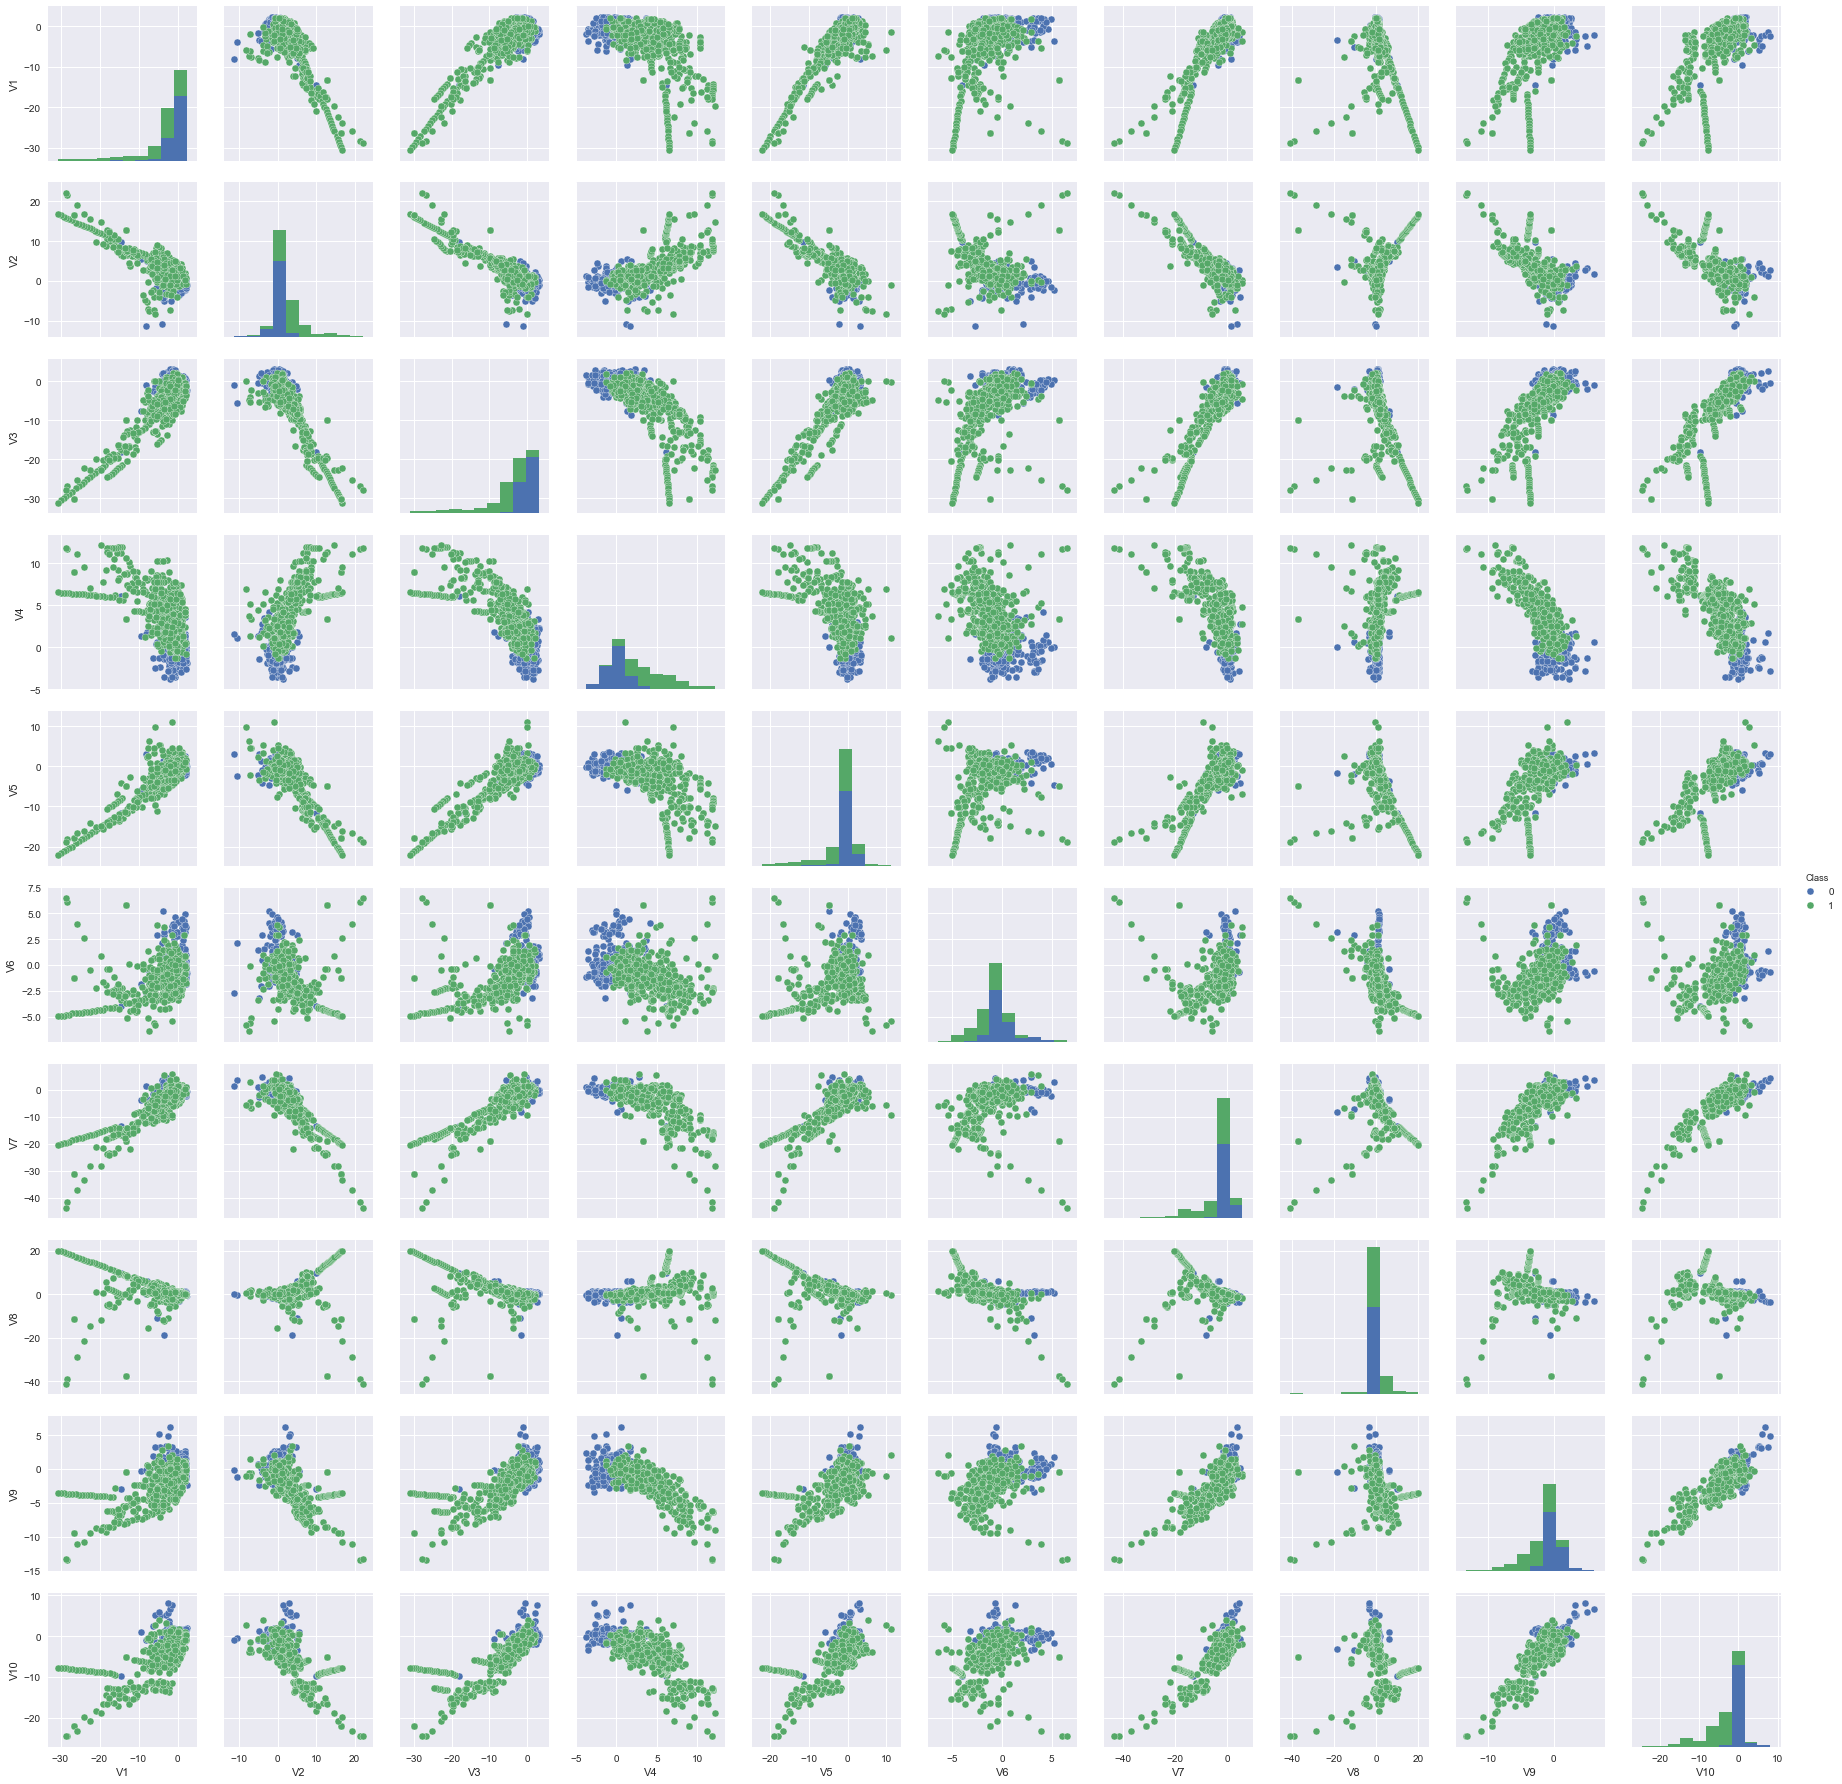

In [21]:
sns.pairplot(data_red_df, hue='Class',vars=['V1','V2','V3','V4', 'V5', 'V6','V7','V8','V9','V10']);

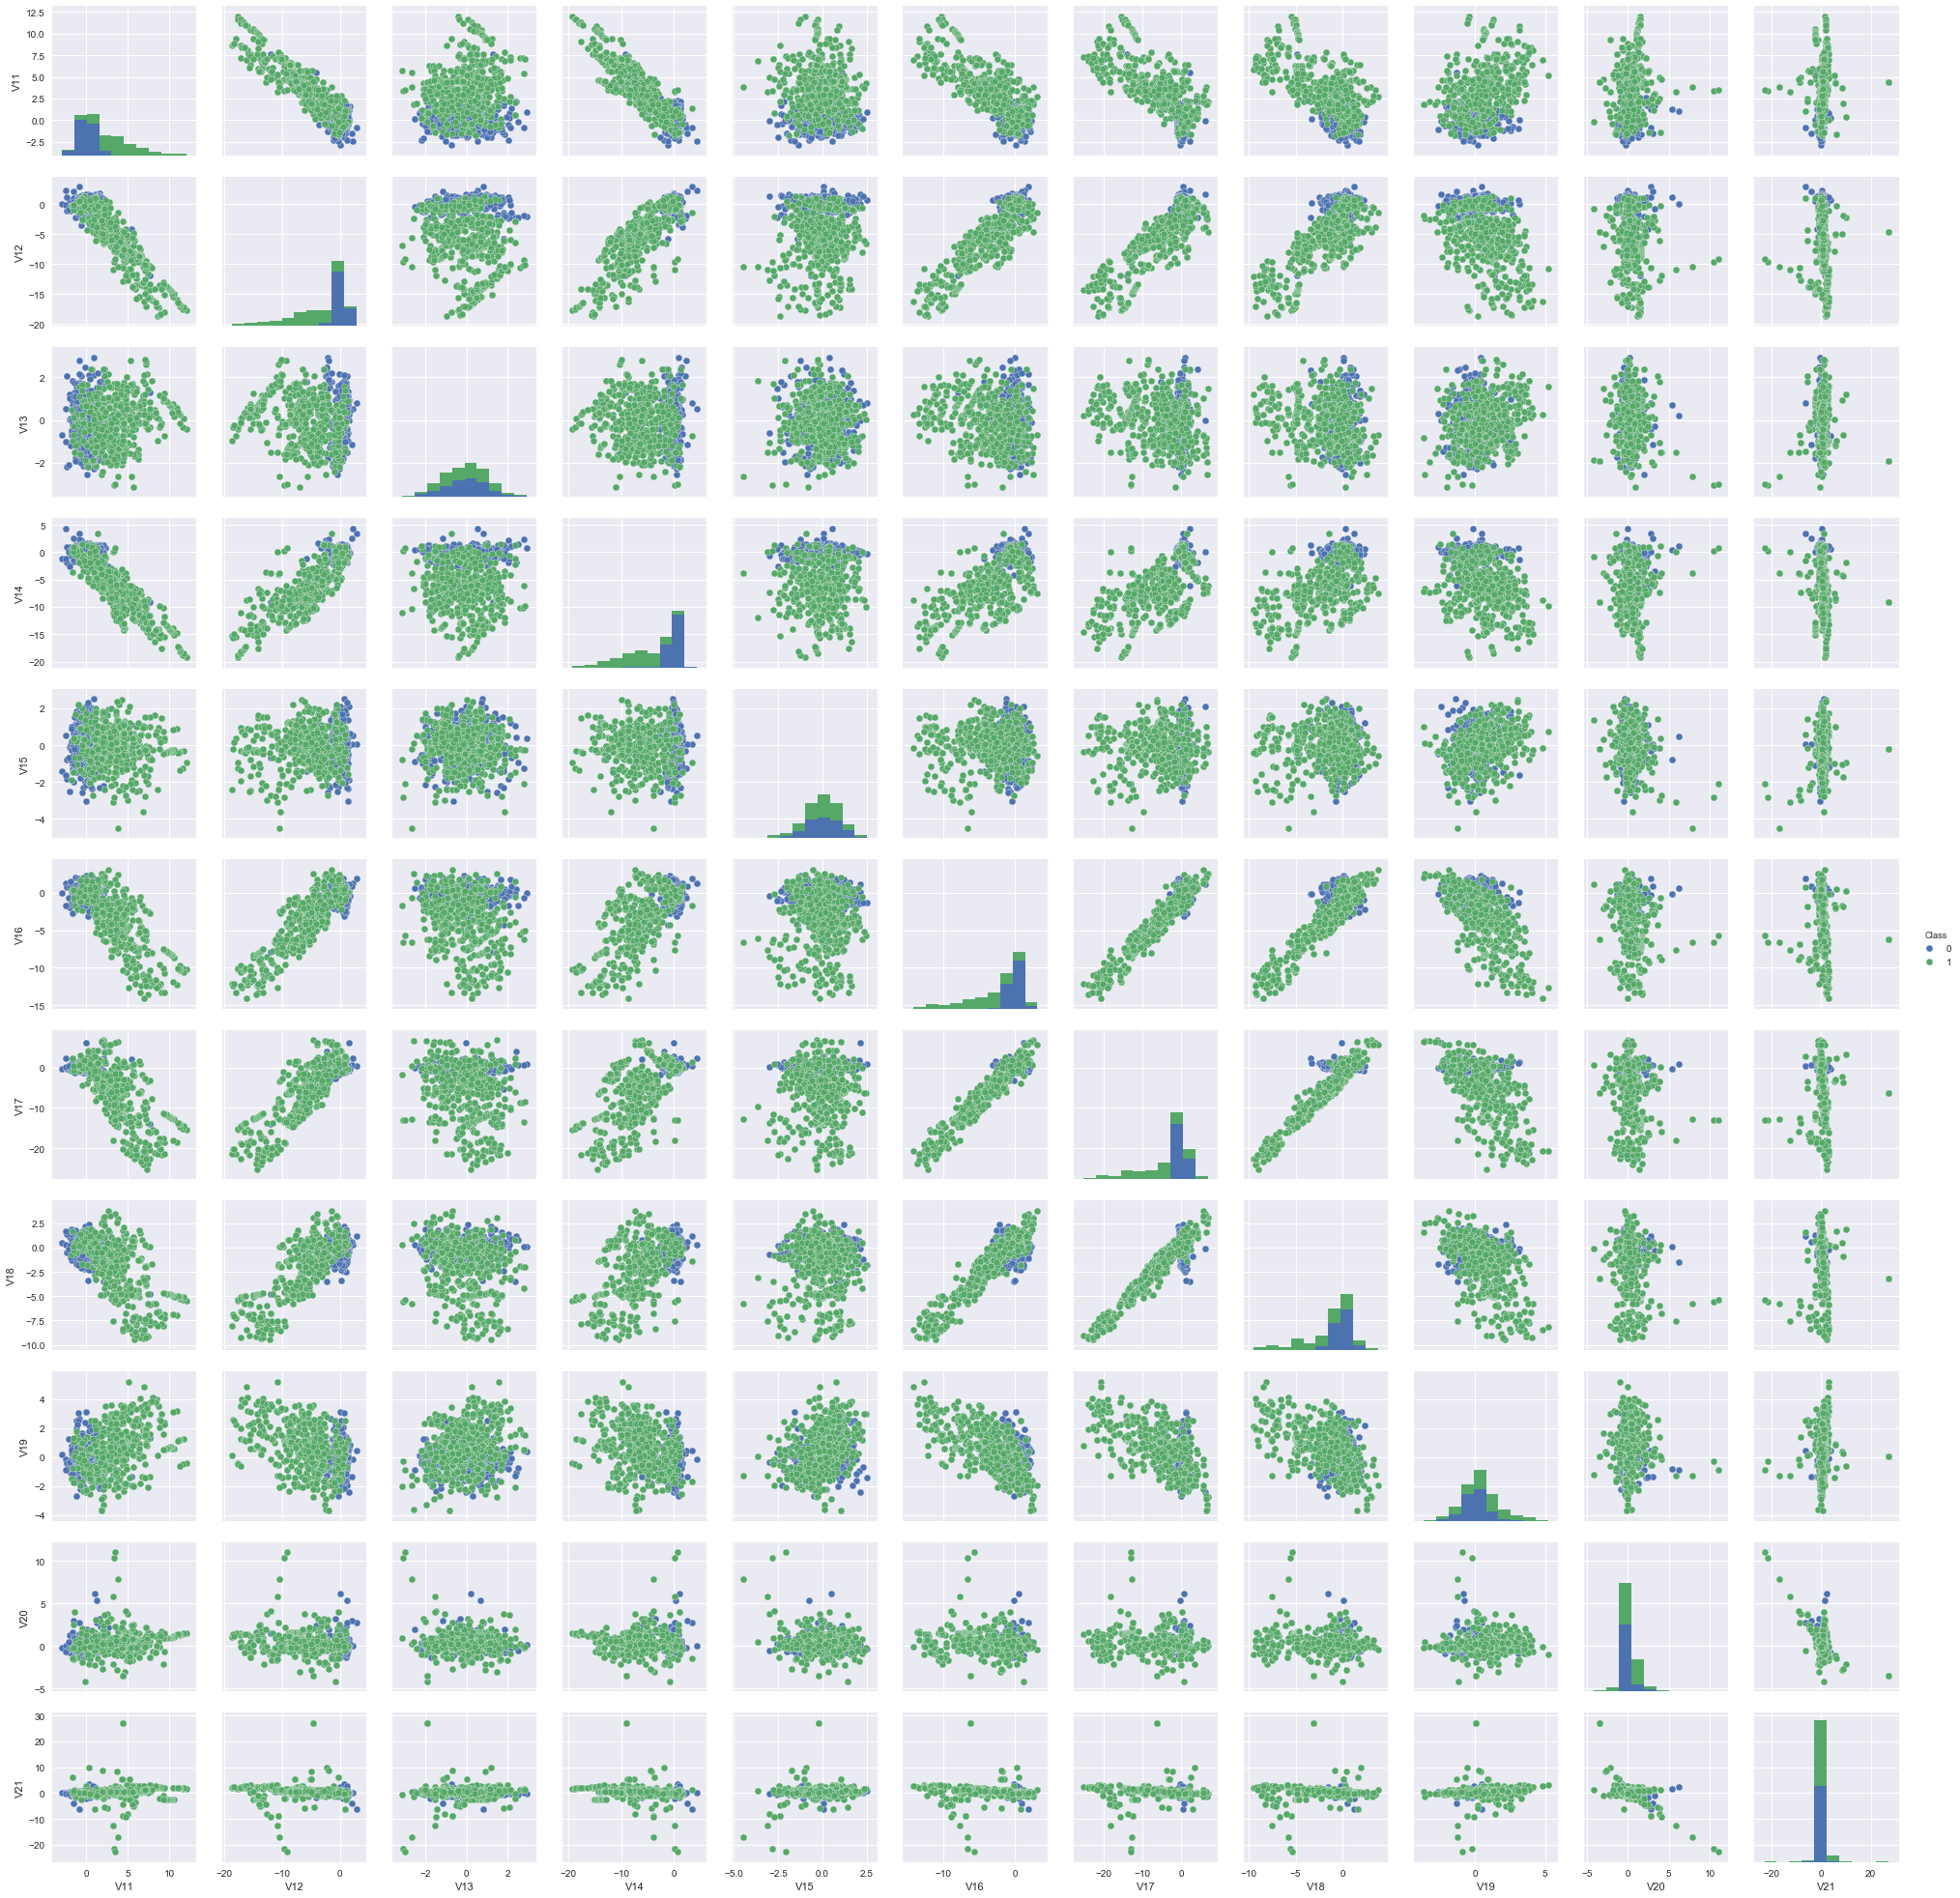

In [22]:
sns.pairplot(data_red_df, hue='Class',vars=[ 'V11', 'V12','V13','V14','V15','V16','V17','V18','V19','V20','V21']);

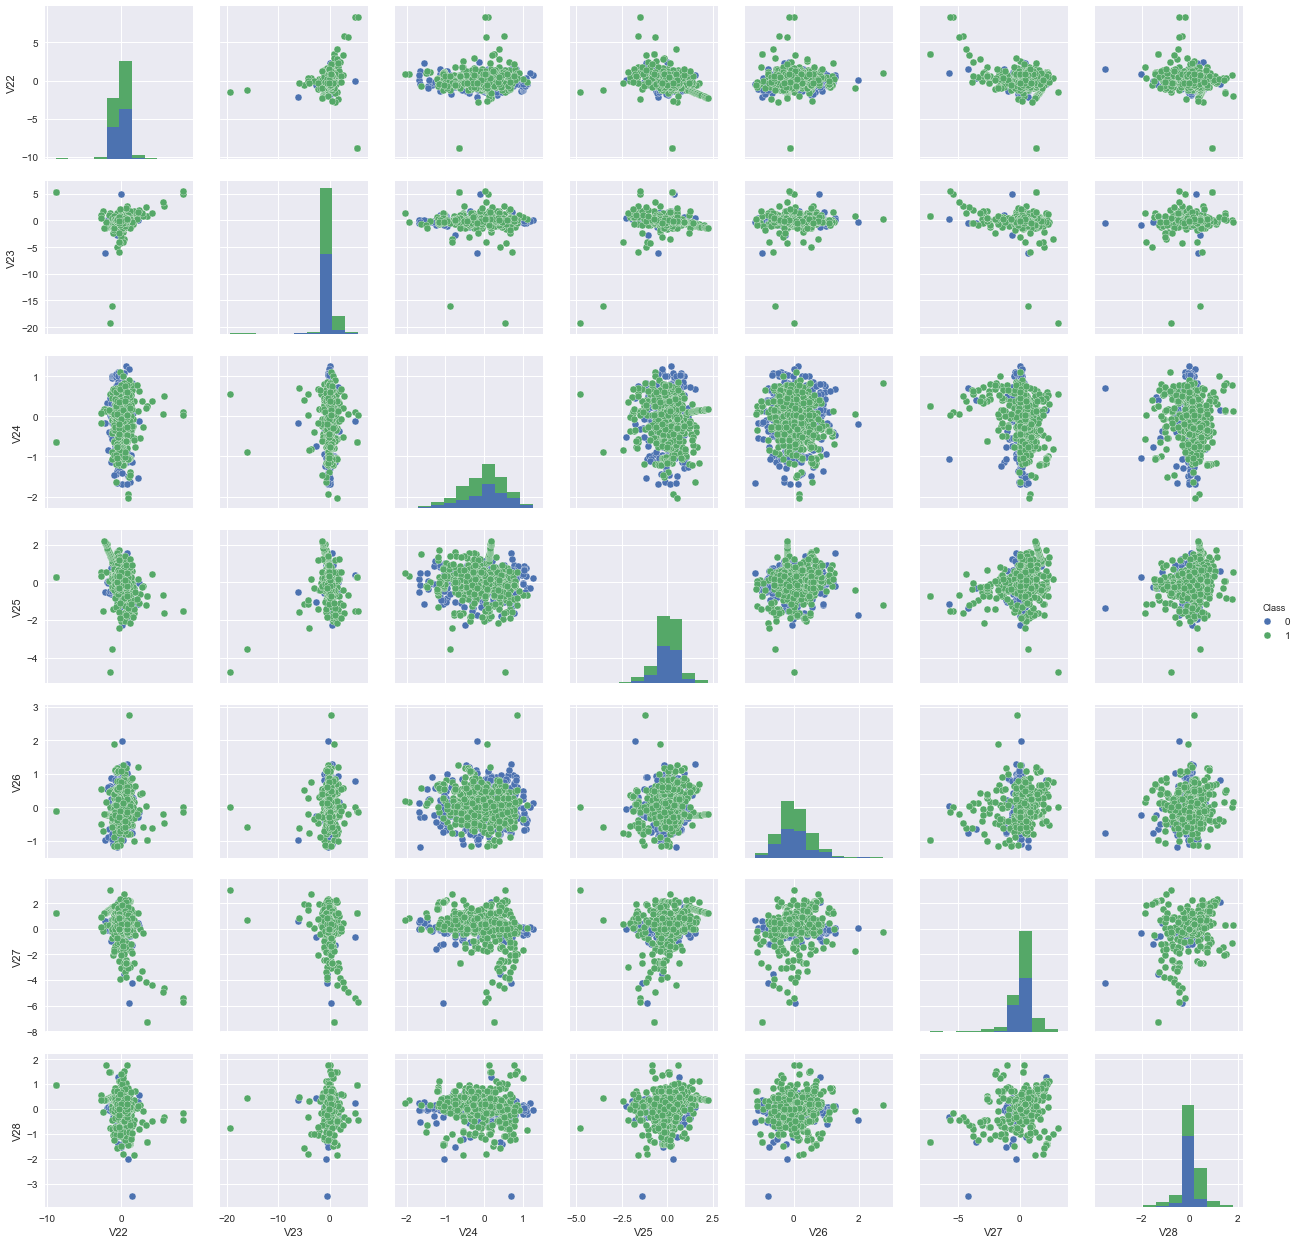

In [23]:
sns.pairplot(data_red_df, hue='Class',vars=[ 'V22','V23','V24','V25','V26','V27','V28']);

It seems that the best features are 'V10', 'V14', 'V16', 'V17'

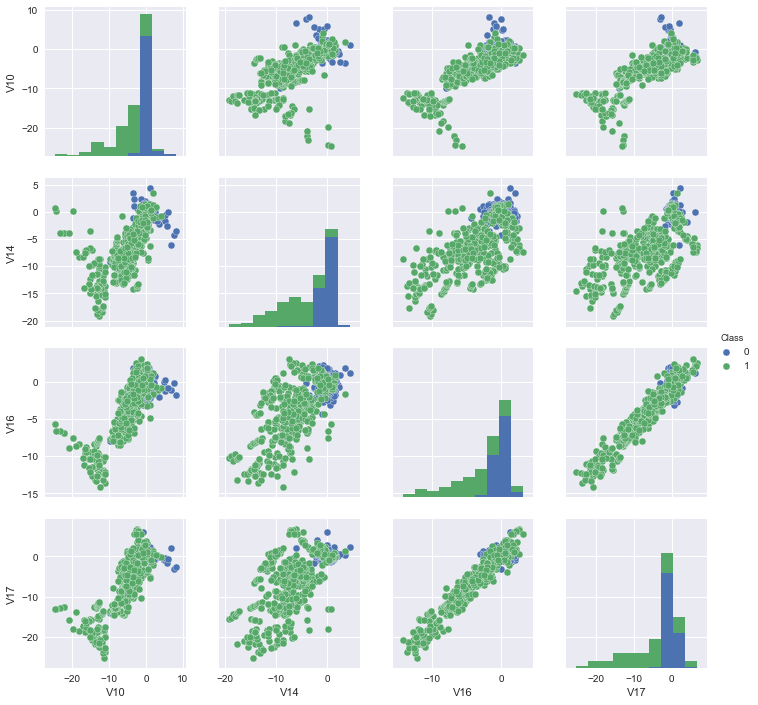

In [24]:
sns.pairplot(data_red_df, hue='Class',vars=['V10','V14','V16','V17']);

Lets take just these columns to fit our algorithms

In [25]:
data_card_df = pd.concat([data_red_df['V10'],data_red_df['V16'],data_red_df['V14'],\
                            data_red_df['V17'],data_red_df['Class']],axis=1)


data_card = data_card_df.as_matrix()

X = data_card[:,:(data_card_df.shape[1]-1)]
y = data_card[:,(data_card_df.shape[1]-1)]


In [26]:
iso.fit(X[:50,:])
data_projected = iso.transform(X)
data_projected.shape

(984, 2)

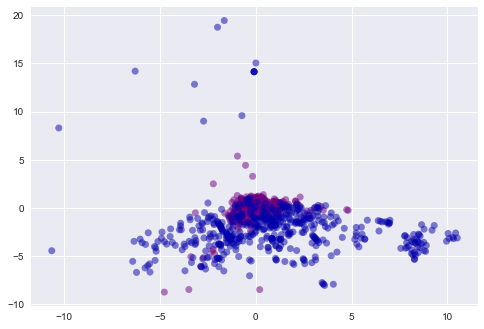

In [27]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=y,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral'))

plt.clim(-0.5, 9.5);

Lets now divide the data into training and test data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Decision Tree classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

#fit decision tree classifier
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

#predict 'y' for test data
y_pred_test_dt = model_dt.predict(X_test)

#score
print(confusion_matrix(y_test, y_pred_test_dt))
print(f1_score(y_test, y_pred_test_dt))

[[103  10]
 [ 14 119]]
0.908396946565


# Neural networks

In [30]:
#fit data
model_nn.fit(X_train, y_train)

#predict y
y_pred_test_nn = model_nn.predict(X_test)

#score
print(confusion_matrix(y_test, y_pred_test_nn))
print(f1_score(y_test, y_pred_test_nn))

[[112   1]
 [ 19 114]]
0.91935483871


# Random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

#fit
model_rf = RandomForestClassifier(criterion='entropy')
model_rf.fit(X_train, y_train)

#predict y
y_pred_test_rf = model_rf.predict(X_test)

#score
print(confusion_matrix(y_test, y_pred_test_rf))
print(f1_score(y_test, y_pred_test_rf))


[[110   3]
 [ 17 116]]
0.920634920635


Seems the results don't improve much.
Lets look at the cross valudation accuracy:

In [32]:
cv = KFold(len(y), 5, shuffle=True, random_state=0)

scores_dt = cross_val_score(model_dt, X, y, cv=cv)
print(scores_dt)
print("Mean score decision tree: {0:.3f} (+/-{1:.3f})".format(np.mean(scores_dt), sem(scores_dt)))

[ 0.9035533   0.89340102  0.92893401  0.87817259  0.90306122]
Mean score decision tree: 0.901 (+/-0.008)


In [33]:
cv = KFold(len(y), 5, shuffle=True, random_state=0)

scores_nn = cross_val_score(model_nn, X, y, cv=cv)
print(scores_nn)
print("Mean score neural networks: {0:.3f} (+/-{1:.3f})".format(np.mean(scores_nn), sem(scores_nn)))

[ 0.9035533   0.93908629  0.92385787  0.89340102  0.94387755]
Mean score neural networks: 0.921 (+/-0.010)


In [34]:
scores_rf = cross_val_score(model_rf, X, y, cv=cv)
print(scores_rf)
print("Mean score rando forest: {0:.3f} (+/-{1:.3f})".format(np.mean(scores_rf), sem(scores_rf)))

[ 0.90862944  0.94416244  0.93908629  0.89847716  0.93877551]
Mean score rando forest: 0.926 (+/-0.009)
